# GET DATA

In [ ]:
import psycopg2
import networkx as nx
import torch
from torch_geometric.utils import from_networkx

from pyvis.network import Network   # <--- QUI LA NOVITÀ

# connessione al DB
conn = psycopg2.connect(

)
cur = conn.cursor()

# query edges
query_edges = """
SELECT
    from_address,
    to_address,
    SUM(flow_amount) AS total_btc_sent
FROM flows
WHERE from_address IS NOT NULL
  AND to_address IS NOT NULL
  AND from_address <> to_address
GROUP BY from_address, to_address;
"""
cur.execute(query_edges)
rows = cur.fetchall()

# query node features
query_nodes = "SELECT fk_address_code, total_amount FROM wallet;"
cur.execute(query_nodes)
node_rows = cur.fetchall()
node_features = {addr: float(total) for addr, total in node_rows}

# costruisci grafo
G = nx.DiGraph()

for from_addr, to_addr, total_btc in rows:
    G.add_edge(from_addr, to_addr, total_btc=float(total_btc))

# aggiungi feature dei nodi
for node in G.nodes():
    G.nodes[node]['total_btc'] = node_features.get(node, 0.0)

# map addresses → numeric ids
mapping = {addr: i for i, addr in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)

# convert to PyG
data = from_networkx(G)

# edge features
data.edge_attr = torch.tensor(
    [[attr['total_btc']] for _,_,attr in G.edges(data=True)],
    dtype=torch.float
)

# node features reali
data.x = torch.tensor(
    [[attr['total_btc']] for _, attr in G.nodes(data=True)],
    dtype=torch.float
)

In [ ]:

# ----------------------------------------------------------------------
# 🎨 VISUALIZZAZIONE INTERATTIVA DEL GRAFO CON PYVIS (NO SCIPY, NO MATPLOTLIB)
# ----------------------------------------------------------------------

net = Network(height="900px", width="100%", directed=True, bgcolor="#111111", font_color="white")

# aggiungi nodi
for node, attrs in G.nodes(data=True):
    net.add_node(
        node,
        label=str(node),
        title=f"Total BTC: {attrs['total_btc']}",
        color="#3DA5FF"
    )

# aggiungi archi
for src, dst, attrs in G.edges(data=True):
    net.add_edge(
        src,
        dst,
        title=f"Flow: {attrs['total_btc']}",
        color="#AAAAAA"
    )

# salva e apri
output_file = "bitcoin_graph.html"
net.write_html(output_file)
print(output_file)

print(f"Grafo salvato in: {output_file}")

# EXAMPLE

Epoch 001 | Loss: 13.582227
Epoch 002 | Loss: 7.119119
Epoch 003 | Loss: 2.636237
Epoch 004 | Loss: 5.618621
Epoch 005 | Loss: 6.373618
Epoch 006 | Loss: 5.274985
Epoch 007 | Loss: 3.328491
Epoch 008 | Loss: 2.347483
Epoch 009 | Loss: 3.592721
Epoch 010 | Loss: 4.163307
Epoch 011 | Loss: 3.814058
Epoch 012 | Loss: 2.790238
Epoch 013 | Loss: 2.069401
Epoch 014 | Loss: 2.522298
Epoch 015 | Loss: 3.247055
Epoch 016 | Loss: 2.994392
Epoch 017 | Loss: 2.154398
Epoch 018 | Loss: 1.903875
Epoch 019 | Loss: 2.389116
Epoch 020 | Loss: 2.812666
Epoch 021 | Loss: 2.810201
Epoch 022 | Loss: 2.248621
Epoch 023 | Loss: 1.923262
Epoch 024 | Loss: 2.147658
Epoch 025 | Loss: 2.378678
Epoch 026 | Loss: 2.345424
Epoch 027 | Loss: 2.069581
Epoch 028 | Loss: 1.965425
Epoch 029 | Loss: 1.917994
Epoch 030 | Loss: 2.154042
Epoch 031 | Loss: 2.003044
Epoch 032 | Loss: 1.969001
Epoch 033 | Loss: 1.792115
Epoch 034 | Loss: 1.716385
Epoch 035 | Loss: 1.904379
Epoch 036 | Loss: 1.991133
Epoch 037 | Loss: 1.944110


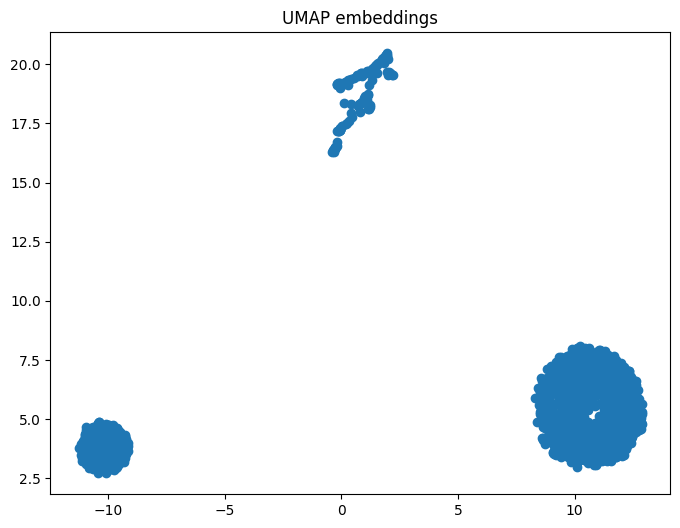

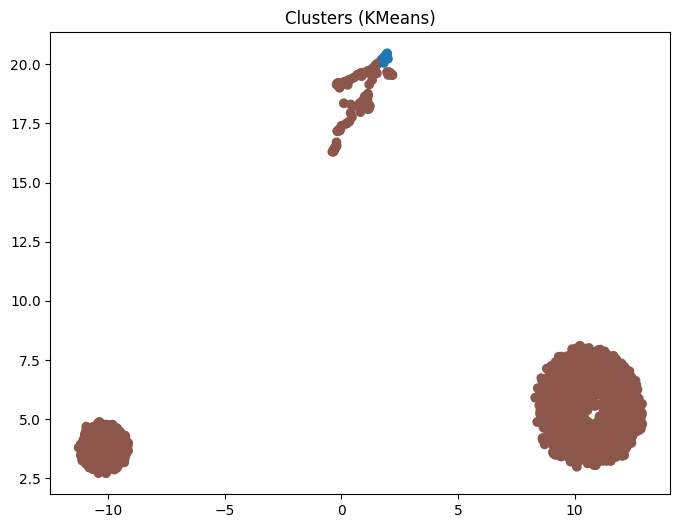

Cluster labels: [1 2 1 ... 1 1 1]


In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import umap
import networkx as nx
from torch_geometric.utils import from_networkx

# -------------------------
# 1) CREA UN GRAFO DI TEST
# -------------------------

# aggiungo feature 1D (feature = grado del nodo)
for n in G.nodes():
    G.nodes[n]['feat'] = float(G.degree[n])

data = from_networkx(G)
data.x = torch.tensor([[f['feat']] for _, f in G.nodes(data=True)], dtype=torch.float)
data.edge_index = data.edge_index.long()

device = "cuda" if torch.cuda.is_available() else "cpu"
data = data.to(device)

# -----------------------------------
# 2) DEFINIZIONE ENCODER (GraphSAGE)
# -----------------------------------

class SAGEEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


# ------------------------------
# 3) DGI FATTO A MANO (ROBUSTO)
# ------------------------------

class MyDGI(torch.nn.Module):
    def __init__(self, encoder, hidden_channels):
        super().__init__()
        self.encoder = encoder
        self.hidden_channels = hidden_channels
        self.weight = torch.nn.Parameter(torch.randn(hidden_channels, hidden_channels))

    def corruption(self, x):
        # permuta le feature
        perm = torch.randperm(x.size(0), device=x.device)
        return x[perm]

    def summary(self, z):
        # summary globale (mean pooling)
        return torch.sigmoid(z.mean(dim=0))

    def forward(self, x, edge_index):
        pos_z = self.encoder(x, edge_index)
        neg_z = self.encoder(self.corruption(x), edge_index)
        summary = self.summary(pos_z)
        return pos_z, neg_z, summary

    def loss(self, pos_z, neg_z, summary):
        s = summary @ self.weight
        pos = (pos_z * s).sum(dim=1)
        neg = (neg_z * s).sum(dim=1)
        return -torch.log(torch.sigmoid(pos) + 1e-15).mean() \
               - torch.log(1 - torch.sigmoid(neg) + 1e-15).mean()


# ----------------------------
# 4) INIZIALIZZA TUTTO
# ----------------------------

hidden = 64
encoder = SAGEEncoder(data.x.size(1), hidden).to(device)
dgi = MyDGI(encoder, hidden).to(device)
optimizer = torch.optim.Adam(dgi.parameters(), lr=0.001)

x, edge_index = data.x, data.edge_index

# ----------------------------
# 5) TRAINING
# ----------------------------
epochs = 150

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    pos_z, neg_z, summary = dgi(x, edge_index)
    loss = dgi.loss(pos_z, neg_z, summary)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch:03d} | Loss: {loss.item():.6f}")

# ----------------------------
# 6) EMBEDDINGS FINALI
# ----------------------------

emb = encoder(x, edge_index).detach().cpu().numpy()
print("\nEmbeddings shape:", emb.shape)

# ----------------------------
# 7) UMAP 2D
# ----------------------------

umap_2d = umap.UMAP(n_neighbors=10, min_dist=0.3).fit_transform(emb)

plt.figure(figsize=(8,6))
plt.scatter(umap_2d[:,0], umap_2d[:,1])
plt.title("UMAP embeddings")
plt.show()

# ----------------------------
# 8) CLUSTERING
# ----------------------------

kmeans = KMeans(n_clusters=3, n_init=20).fit(emb)
labels = kmeans.labels_

plt.figure(figsize=(8,6))
plt.scatter(umap_2d[:,0], umap_2d[:,1], c=labels, cmap="tab10")
plt.title("Clusters (KMeans)")
plt.show()

print("Cluster labels:", labels)